# Notebook to make Fig. 15

In [1]:
# Import necessary packages & set-up plotting aesthetics
import numpy as np 
import pylab
import pandas as pd
from scipy.stats import gaussian_kde
import json

import matplotlib
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
from matplotlib import style

from fig_helper_functions import *

style.use('plotting.mplstyle')

import sys
sys.path.append('./../Code/PopulationInference')
from posterior_helper_functions import mu_sigma2_to_a_b, calculate_betaDistribution, calculate_Double_Gaussian

import seaborn as sns
sns.set_palette('colorblind')

### Load data

Underlying populations

In [2]:
f_root = '../Data/InjectedPopulationParameters/' 
pop1 = pd.read_json(f_root+'underlying_population1_highSpinPrecessing_fullmassrange.json')
pop2 = pd.read_json(f_root+'underlying_population2_mediumSpin_fullmassrange.json')
pop3 = pd.read_json(f_root+'underlying_population3_lowSpinAligned_fullmassrange.json')

# Set up grids to evaluate KDEs on
chi_grid = np.linspace(0,1,500)
cost_grid =  np.linspace(-1,1,500)

# Dict in which to store KDEs
kde_dict = {}

# Cycle through populations
for pop,pop_key in zip([pop1, pop2, pop3], ['pop 1', 'pop 2', 'pop 3']):
    
    # Use function in fig_helper_functions
    kde_dict[pop_key] = get_KDE_dict_spins(pop)

`emcee` hierarchical inference samples

In [3]:
# For loading files
fnames = {
    'pop 3 70 events':'betaPlusDoubleGaussian/103023_betaPlusDoubleGaussian_pop3_70events.json', 
    'pop 3 300 events':'betaPlusDoubleGaussian/103023_betaPlusDoubleGaussian_pop3_300events.json',
    'pop 3 70 events 2':'betaPlusDoubleGaussian2/110623_betaPlusDoubleGaussian2_pop3_70events.json', 
    'pop 3 300 events 2':'betaPlusDoubleGaussian2/110623_betaPlusDoubleGaussian2_pop3_300events.json',
    'pop 3 70 events 2 no selection':'betaPlusDoubleGaussian2_noSelectionSpins/103123_betaPlusDoubleGaussian2_noSelectionSpins_pop3_70events.json', 
    'pop 3 300 events 2 no selection':'betaPlusDoubleGaussian2_noSelectionSpins/103123_betaPlusDoubleGaussian2_noSelectionSpins_pop3_300events.json',
}


# Make Dict
data_dict = {}

for run, fname in fnames.items(): 
    
    print(run)
    
    data_dir = f'../Data/PopulationInferenceOutput/'
    name = data_dir+fname

    with open(name, 'r') as f:
        data = json.load(f)
        
    data_dict[run] = data 

pop 3 70 events
pop 3 300 events
pop 3 70 events 2
pop 3 300 events 2
pop 3 70 events 2 no selection
pop 3 300 events 2 no selection


### Generate traces

In [6]:
# Make dict 
traces_dict = {}

# Choose a number of traces to draw
nTracesMax = 1000

# Cycle through runs
for run in fnames.keys(): 
    
    print(run)
    
    # Fetch data
    data = data_dict[run]
        
    # Instantiate an array to hold a collection of traces
    nTraces = min(nTracesMax, len(data['mu_chi']['processed']))
    p_chi = np.zeros((nTraces,chi_grid.size))
    p_cost = np.zeros((nTraces,cost_grid.size))

    # For a random set of posterior samples, compute and store the corresponding probability densities across our grid
    random_indices = np.random.choice(np.arange(len(data['mu_chi']['processed'])), size=nTraces,replace=False)
    for i,ind in enumerate(random_indices):

        print(i, end='\r')

        mu_chi = data['mu_chi']['processed'][ind]
        sigma_chi = data['sigma_chi']['processed'][ind]
        mu1_cost = data['mu1_cost']['processed'][ind]
        sigma1_cost = data['sigma1_cost']['processed'][ind]
        mu2_cost = data['mu2_cost']['processed'][ind]
        sigma2_cost = data['sigma2_cost']['processed'][ind]
        MF_cost = data['MF_cost']['processed'][ind]
        Bq = data['Bq']['processed'][ind]

        # calculate gaussian distribution for chi
        a,b = mu_sigma2_to_a_b(mu_chi, sigma_chi**2)
        p_chi[i,:] = calculate_betaDistribution(chi_grid, a, b)

        # and gaussian distribution for cos(theta)
        p_cost[i,:] = calculate_Double_Gaussian(cost_grid, mu1_cost, sigma1_cost, mu2_cost, sigma2_cost, MF_cost, -1, 1)

    # Add to dict 
    traces_dict[run] = {'p_chi':p_chi, 'p_cost':p_cost} 

pop 3 70 events
pop 3 300 events
pop 3 70 events 2
pop 3 300 events 2
pop 3 70 events 2 no selection
pop 3 300 events 2 no selection


### Plot spin distributions for each population

In [75]:
colors_dict = {
    'pop 3 70 events':dict(color='C9', ls='--', alpha=0.1),
    'pop 3 300 events':dict(color='C0', ls='-', alpha=0.3),
    'pop 3 70 events 2':dict(color='C1', ls='--', alpha=0.1),
    'pop 3 300 events 2':dict(color='C3', ls='-', alpha=0.3),
    'pop 3 70 events 2 no selection':dict(color='C6', ls='--', alpha=0.1),
    'pop 3 300 events 2 no selection':dict(color='C4', ls='-', alpha=0.3)
}

labels_dict = {
    'pop 3 70 events':r'70 events, $\mu_{1,\cos\theta}<\mu_{2,\cos\theta}$',
    'pop 3 300 events':r'300 events, $\mu_{1,\cos\theta}<\mu_{2,\cos\theta}$',
    'pop 3 70 events 2':'70 events, $f<0.5$',
    'pop 3 300 events 2':'300 events, $f<0.5$',
    'pop 3 70 events 2 no selection':'70 events, $f<0.5$, no spin\nselection',
    'pop 3 300 events 2 no selection':'300 events, $f<0.5$, no spin\nselection'
}

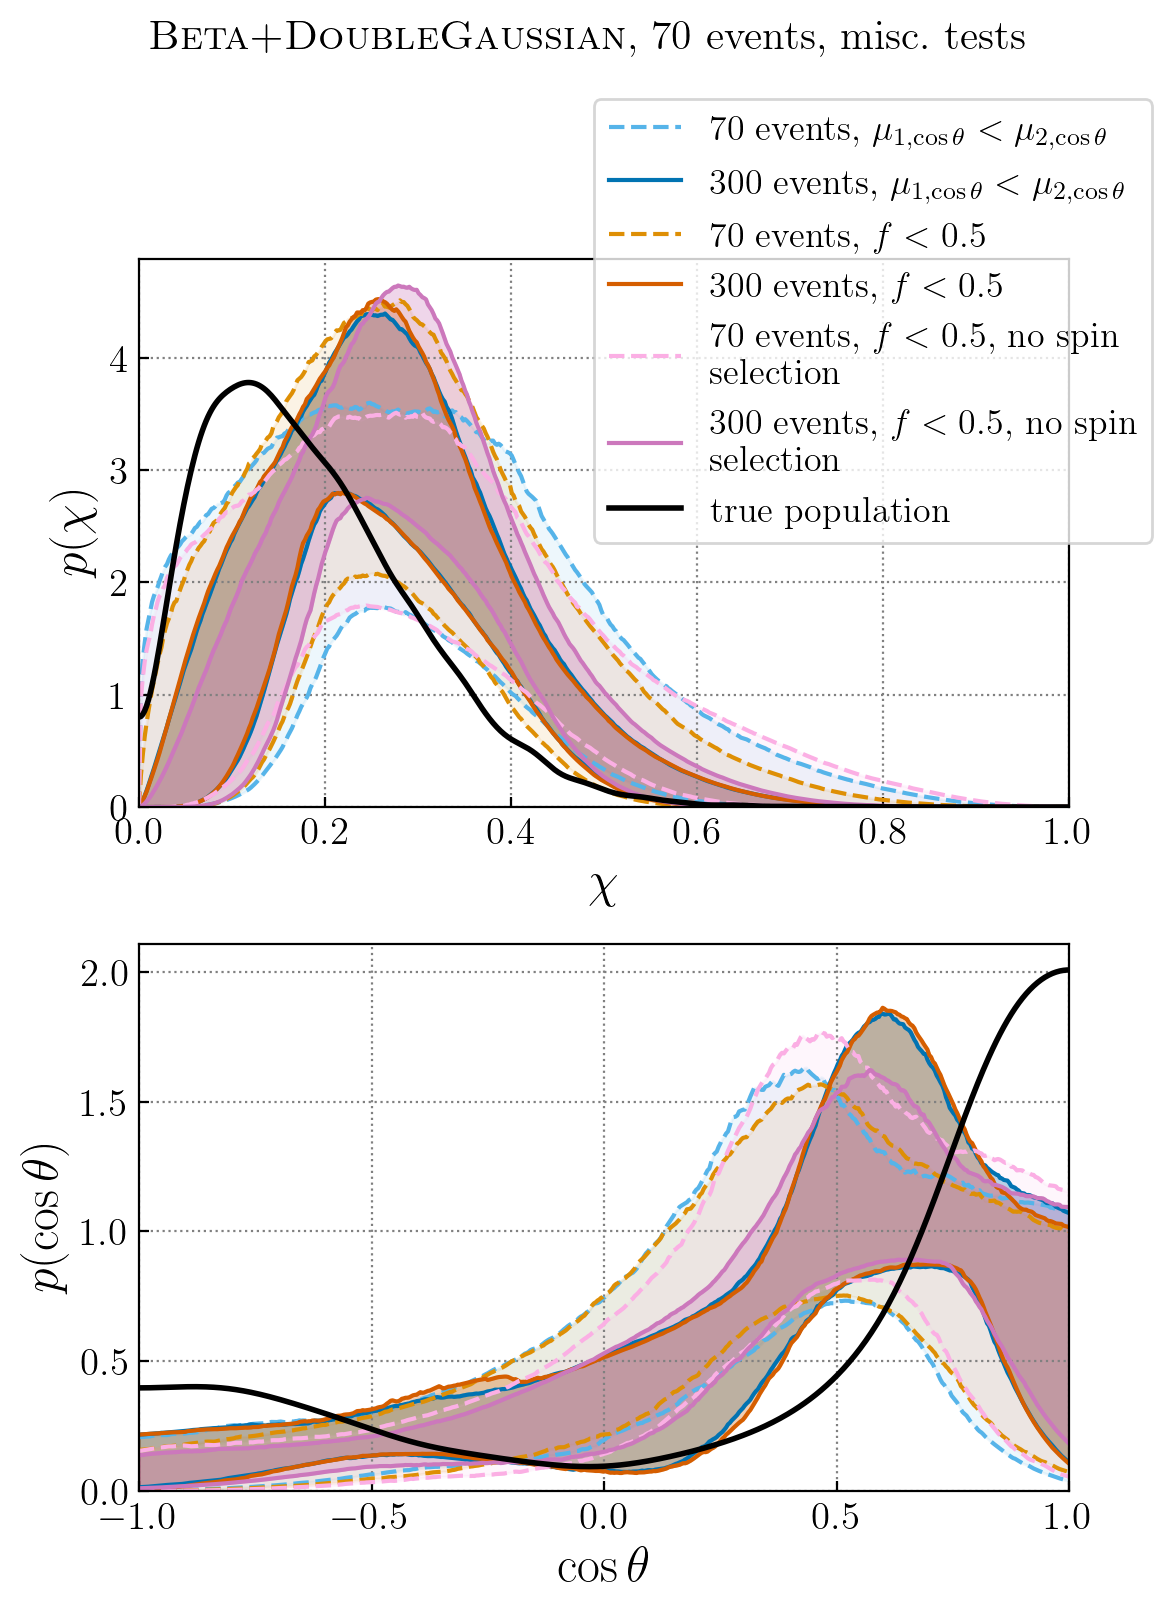

In [86]:
fig,axes = plt.subplots(2, 1, figsize=(6, 8))

for i,run in enumerate(fnames.keys()):
    
    c = colors_dict[run]['color']
    ls = colors_dict[run]['ls']
    alph = colors_dict[run]['alpha']
    lbl = labels_dict[run]
    
    # spin magnitude
    p_chi = traces_dict[run]['p_chi']
    chi_quants = np.quantile(p_chi, (0.05, 0.95), axis=0)
    axes[0].plot(chi_grid, chi_quants[0], color=c, ls=ls, label=lbl)
    axes[0].plot(chi_grid, chi_quants[1], color=c, ls=ls)
    axes[0].fill_between(chi_grid, chi_quants[0], y2=chi_quants[1], color=c, alpha=alph)

    # tilt angle
    p_cost = traces_dict[run]['p_cost']
    cost_quants = np.quantile(p_cost, (0.05, 0.95), axis=0)
    axes[1].plot(cost_grid, cost_quants.T, color=c, ls=ls)
    axes[1].fill_between(cost_grid, cost_quants[0], y2=cost_quants[1], color=c, alpha=alph)

# Plot truth
axes[0].plot(chi_grid, kde_dict[pop_key]['chi'], color='k', lw=2, label='true population')
axes[1].plot(cost_grid, kde_dict[pop_key]['cost'], color='k', lw=2)

# Axes limits
axes[0].set_xlim(0,1)
axes[0].set_ylim(0,)
axes[1].set_xlim(-1,1)
axes[1].set_ylim(0,)

# Axes labels
axes[0].set_xlabel(r'$\chi$')
axes[0].set_ylabel(r'$p(\chi)$')
axes[1].set_xlabel(r'$\cos\theta$')
axes[1].set_ylabel(r'$p(\cos\theta)$')

# Legend
axes[0].legend(loc='lower left', bbox_to_anchor=(0.47, 0.45), frameon=True, fontsize=13)

# Title
plt.suptitle(r'$\mathrm{\textsc{Beta+DoubleGaussian}}$, 70 events, misc.~tests', fontsize=15, y=1.03)

plt.subplots_adjust(hspace=0.25)
    
plt.savefig('figure_15.pdf',bbox_inches='tight')
plt.show()